<a href="https://colab.research.google.com/github/Rachit64/RugvedTp/blob/main/transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.cuda.amp import GradScaler, autocast

import torchvision
import torchvision.transforms as transforms

from tqdm import tqdm  # For a nice progress bar
import time
import math # For weight initialization

In [3]:
CONFIG = {
    "device": "cuda" if torch.cuda.is_available() else "cpu",

    "img_size": 32,
    "patch_size": 4,
    "in_channels": 3,
    "num_classes": 10,

    "embed_dim": 192,
    "depth": 9,
    "num_heads": 3,
    "mlp_ratio": 2.0,
    "dropout": 0.1,

    "epochs": 50,
    "batch_size": 256,
    "lr": 1e-3,
    "weight_decay": 0.05,
    "grad_clip_val": 1.0
}



In [5]:

class PatchEmbedding(nn.Module):


    def __init__(self, img_size, patch_size, in_channels, embed_dim):
        super().__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.n_patches = (img_size // patch_size) ** 2


        self.proj = nn.Conv2d(
            in_channels,
            embed_dim,
            kernel_size=patch_size,
            stride=patch_size
        )

    def forward(self, x):
        x = self.proj(x)

        x = x.flatten(2)

        x = x.transpose(1, 2)
        return x

class MultiHeadAttention(nn.Module):

    def __init__(self, embed_dim, num_heads, dropout):
        super().__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads

        assert embed_dim % num_heads == 0, "Embedding dimension must be divisible by num_heads"

        self.scale = self.head_dim ** -0.5

        self.qkv = nn.Linear(embed_dim, embed_dim * 3)
        self.attn_drop = nn.Dropout(dropout)

        self.proj = nn.Linear(embed_dim, embed_dim)
        self.proj_drop = nn.Dropout(dropout)

    def forward(self, x):
        B, N, D = x.shape


        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, self.head_dim).permute(2, 0, 3, 1, 4)

        q, k, v = qkv[0], qkv[1], qkv[2]


        attn = (q @ k.transpose(-2, -1)) * self.scale

        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)


        x = (attn @ v).transpose(1, 2).reshape(B, N, D)

        x = self.proj(x)
        x = self.proj_drop(x)

        return x

class MLP(nn.Module):

    def __init__(self, in_features, hidden_features, out_features, dropout):
        super().__init__()
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = nn.GELU() # GELU is the activation function used in ViT
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(dropout)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x

class Block(nn.Module):

    def __init__(self, embed_dim, num_heads, mlp_ratio, dropout):
        super().__init__()
        self.norm1 = nn.LayerNorm(embed_dim)
        self.attn = MultiHeadAttention(
            embed_dim=embed_dim,
            num_heads=num_heads,
            dropout=dropout
        )

        self.norm2 = nn.LayerNorm(embed_dim)
        self.mlp = MLP(
            in_features=embed_dim,
            hidden_features=int(embed_dim * mlp_ratio),
            out_features=embed_dim,
            dropout=dropout
        )

    def forward(self, x):
        x = x + self.attn(self.norm1(x))

        x = x + self.mlp(self.norm2(x))

        return x

In [6]:

def trunc_normal_(tensor, mean=0., std=0.02):
    with torch.no_grad():
        size = tensor.shape
        tmp = tensor.new_empty(size).normal_()
        while tmp.abs().max() > 2 * std:
            tmp[tmp.abs() > 2 * std] = tmp.new_empty(1).normal_()
        tensor.copy_(tmp * std + mean)




class VisionTransformer(nn.Module):

    def __init__(self, img_size, patch_size, in_channels, num_classes,
                 embed_dim, depth, num_heads, mlp_ratio, dropout):
        super().__init__()

        self.patch_embed = PatchEmbedding(
            img_size=img_size,
            patch_size=patch_size,
            in_channels=in_channels,
            embed_dim=embed_dim
        )
        num_patches = self.patch_embed.n_patches

        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))

        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, embed_dim))
        self.pos_drop = nn.Dropout(dropout)

        self.blocks = nn.ModuleList(
            [
                Block(
                    embed_dim=embed_dim,
                    num_heads=num_heads,
                    mlp_ratio=mlp_ratio,
                    dropout=dropout
                )
                for _ in range(depth)
            ]
        )

        self.norm = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, num_classes)

        self._init_weights()

    def _init_weights(self):

        trunc_normal_(self.pos_embed, std=.02)
        trunc_normal_(self.cls_token, std=.02)

        self.apply(self._init_layer_weights)

    def _init_layer_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.weight, 1.0)
            nn.init.constant_(m.bias, 0)

    def forward(self, x):
        B = x.shape[0]

        x = self.patch_embed(x)

        cls_tokens = self.cls_token.expand(B, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)

        x = x + self.pos_embed
        x = self.pos_drop(x)

        for block in self.blocks:
            x = block(x)

        x = self.norm(x)

        cls_output = x[:, 0]

        output = self.head(cls_output)

        return output

In [7]:

def train_one_epoch(model, loader, optimizer, criterion, scaler, device, grad_clip_val):

    model.train()
    total_loss = 0.0

    pbar = tqdm(loader, desc=f"Training", leave=False)

    for inputs, labels in pbar:
        inputs, labels = inputs.to(device), labels.to(device)


        with autocast():
            outputs = model(inputs)
            loss = criterion(outputs, labels)

        optimizer.zero_grad()

        scaler.scale(loss).backward()


        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip_val)

        scaler.step(optimizer)

        scaler.update()

        total_loss += loss.item()
        pbar.set_postfix(loss=loss.item())

    return total_loss / len(loader)

def evaluate(model, loader, criterion, device):

    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0

    pbar = tqdm(loader, desc="Evaluating", leave=False)

    with torch.no_grad():
        for inputs, labels in pbar:
            inputs, labels = inputs.to(device), labels.to(device)

            with autocast():
                outputs = model(inputs)
                loss = criterion(outputs, labels)

            total_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_loss = total_loss / len(loader)
    accuracy = 100 * correct / total
    return avg_loss, accuracy

Starting ViT from Scratch on CIFAR-10...
Configuration:
  device: cuda
  img_size: 32
  patch_size: 4
  in_channels: 3
  num_classes: 10
  embed_dim: 192
  depth: 9
  num_heads: 3
  mlp_ratio: 2.0
  dropout: 0.1
  epochs: 50
  batch_size: 256
  lr: 0.001
  weight_decay: 0.05
  grad_clip_val: 1.0

Loading CIFAR-10 data...
Data loaded successfully.
Initializing ViT model...


/tmp/ipython-input-3734616778.py:89: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Setting up loss, optimizer, and scheduler...
Setup complete.

Starting training for 50 epochs...


Training:   0%|          | 0/196 [00:00<?, ?it/s]/tmp/ipython-input-2827158102.py:14: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]/tmp/ipython-input-2827158102.py:48: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 1/50 | Time: 38.79s | Train Loss: 2.0968 | Val Loss: 1.9010 | Val Acc: 27.50%
  -> New best accuracy! Model saved to 'vit_cifar10_best.pth'


Epoch 2/50 | Time: 37.78s | Train Loss: 1.9641 | Val Loss: 1.8156 | Val Acc: 29.85%
  -> New best accuracy! Model saved to 'vit_cifar10_best.pth'


Epoch 3/50 | Time: 37.87s | Train Loss: 1.8869 | Val Loss: 1.6908 | Val Acc: 35.91%
  -> New best accuracy! Model saved to 'vit_cifar10_best.pth'


Epoch 4/50 | Time: 37.67s | Train Loss: 1.8263 | Val Loss: 1.6522 | Val Acc: 39.25%
  -> New best accuracy! Model saved to 'vit_cifar10_best.pth'


Epoch 5/50 | Time: 37.31s | Train Loss: 1.7629 | Val Loss: 1.4964 | Val Acc: 45.76%
  -> New best accuracy! Model saved to 'vit_cifar10_best.pth'


Epoch 6/50 | Time: 37.38s | Train Loss: 1.7117 | Val Loss: 1.5202 | Val Acc: 44.59%


Epoch 7/50 | Time: 37.00s | Train Loss: 1.6535 | Val Loss: 1.4290 | Val Acc: 48.32%
  -> New best accuracy! Model saved to 'vit_cifar10_best.pth'


Epoch 8/50 | Time: 37.40s | Train Loss: 1.6150 | Val Loss: 1.4342 | Val Acc: 48.04%


Epoch 9/50 | Time: 37.42s | Train Loss: 1.5788 | Val Loss: 1.3473 | Val Acc: 50.86%
  -> New best accuracy! Model saved to 'vit_cifar10_best.pth'


Epoch 10/50 | Time: 37.53s | Train Loss: 1.5393 | Val Loss: 1.2912 | Val Acc: 52.80%
  -> New best accuracy! Model saved to 'vit_cifar10_best.pth'


Epoch 11/50 | Time: 37.78s | Train Loss: 1.5039 | Val Loss: 1.2490 | Val Acc: 55.11%
  -> New best accuracy! Model saved to 'vit_cifar10_best.pth'


Epoch 12/50 | Time: 38.03s | Train Loss: 1.4763 | Val Loss: 1.1827 | Val Acc: 56.61%
  -> New best accuracy! Model saved to 'vit_cifar10_best.pth'


Epoch 13/50 | Time: 37.62s | Train Loss: 1.4400 | Val Loss: 1.1643 | Val Acc: 58.04%
  -> New best accuracy! Model saved to 'vit_cifar10_best.pth'


Epoch 14/50 | Time: 37.58s | Train Loss: 1.4099 | Val Loss: 1.1015 | Val Acc: 60.37%
  -> New best accuracy! Model saved to 'vit_cifar10_best.pth'


Epoch 15/50 | Time: 37.44s | Train Loss: 1.3699 | Val Loss: 1.0624 | Val Acc: 61.77%
  -> New best accuracy! Model saved to 'vit_cifar10_best.pth'


Epoch 16/50 | Time: 37.21s | Train Loss: 1.3419 | Val Loss: 1.0069 | Val Acc: 63.93%
  -> New best accuracy! Model saved to 'vit_cifar10_best.pth'


Epoch 17/50 | Time: 37.60s | Train Loss: 1.3206 | Val Loss: 1.0134 | Val Acc: 63.29%


Epoch 18/50 | Time: 37.46s | Train Loss: 1.2891 | Val Loss: 0.9847 | Val Acc: 63.99%
  -> New best accuracy! Model saved to 'vit_cifar10_best.pth'


Epoch 19/50 | Time: 38.08s | Train Loss: 1.2652 | Val Loss: 0.9730 | Val Acc: 64.71%
  -> New best accuracy! Model saved to 'vit_cifar10_best.pth'


Epoch 20/50 | Time: 38.15s | Train Loss: 1.2427 | Val Loss: 0.9472 | Val Acc: 66.53%
  -> New best accuracy! Model saved to 'vit_cifar10_best.pth'


Epoch 21/50 | Time: 37.89s | Train Loss: 1.2153 | Val Loss: 0.9050 | Val Acc: 68.18%
  -> New best accuracy! Model saved to 'vit_cifar10_best.pth'


Epoch 22/50 | Time: 37.22s | Train Loss: 1.1957 | Val Loss: 0.8976 | Val Acc: 67.83%


Epoch 23/50 | Time: 37.78s | Train Loss: 1.1820 | Val Loss: 0.8845 | Val Acc: 68.22%
  -> New best accuracy! Model saved to 'vit_cifar10_best.pth'


Epoch 24/50 | Time: 37.86s | Train Loss: 1.1498 | Val Loss: 0.8507 | Val Acc: 69.70%
  -> New best accuracy! Model saved to 'vit_cifar10_best.pth'


Epoch 25/50 | Time: 38.08s | Train Loss: 1.1300 | Val Loss: 0.8304 | Val Acc: 70.54%
  -> New best accuracy! Model saved to 'vit_cifar10_best.pth'


Epoch 26/50 | Time: 38.20s | Train Loss: 1.1179 | Val Loss: 0.8231 | Val Acc: 70.85%
  -> New best accuracy! Model saved to 'vit_cifar10_best.pth'


Epoch 27/50 | Time: 38.05s | Train Loss: 1.1045 | Val Loss: 0.8241 | Val Acc: 70.44%


Epoch 28/50 | Time: 38.19s | Train Loss: 1.0863 | Val Loss: 0.7944 | Val Acc: 71.56%
  -> New best accuracy! Model saved to 'vit_cifar10_best.pth'


Epoch 29/50 | Time: 37.88s | Train Loss: 1.0647 | Val Loss: 0.7879 | Val Acc: 71.84%
  -> New best accuracy! Model saved to 'vit_cifar10_best.pth'


Epoch 30/50 | Time: 37.90s | Train Loss: 1.0518 | Val Loss: 0.7330 | Val Acc: 74.02%
  -> New best accuracy! Model saved to 'vit_cifar10_best.pth'


Epoch 31/50 | Time: 38.32s | Train Loss: 1.0433 | Val Loss: 0.7320 | Val Acc: 74.19%
  -> New best accuracy! Model saved to 'vit_cifar10_best.pth'


Epoch 32/50 | Time: 37.96s | Train Loss: 1.0221 | Val Loss: 0.7563 | Val Acc: 73.23%


Epoch 33/50 | Time: 37.96s | Train Loss: 1.0123 | Val Loss: 0.7213 | Val Acc: 74.90%
  -> New best accuracy! Model saved to 'vit_cifar10_best.pth'


Epoch 34/50 | Time: 38.17s | Train Loss: 1.0008 | Val Loss: 0.7166 | Val Acc: 74.99%
  -> New best accuracy! Model saved to 'vit_cifar10_best.pth'


Epoch 35/50 | Time: 38.11s | Train Loss: 0.9899 | Val Loss: 0.6955 | Val Acc: 75.48%
  -> New best accuracy! Model saved to 'vit_cifar10_best.pth'


Epoch 36/50 | Time: 37.81s | Train Loss: 0.9777 | Val Loss: 0.6874 | Val Acc: 75.87%
  -> New best accuracy! Model saved to 'vit_cifar10_best.pth'


Epoch 37/50 | Time: 37.93s | Train Loss: 0.9663 | Val Loss: 0.7139 | Val Acc: 74.97%


Epoch 38/50 | Time: 37.79s | Train Loss: 0.9527 | Val Loss: 0.6897 | Val Acc: 75.44%


Epoch 39/50 | Time: 37.86s | Train Loss: 0.9476 | Val Loss: 0.6575 | Val Acc: 76.66%
  -> New best accuracy! Model saved to 'vit_cifar10_best.pth'


Epoch 40/50 | Time: 37.27s | Train Loss: 0.9380 | Val Loss: 0.6739 | Val Acc: 76.40%


Epoch 41/50 | Time: 37.70s | Train Loss: 0.9326 | Val Loss: 0.6628 | Val Acc: 76.63%


Epoch 42/50 | Time: 38.02s | Train Loss: 0.9181 | Val Loss: 0.6527 | Val Acc: 77.23%
  -> New best accuracy! Model saved to 'vit_cifar10_best.pth'


Epoch 43/50 | Time: 37.73s | Train Loss: 0.9158 | Val Loss: 0.6534 | Val Acc: 77.02%


Epoch 44/50 | Time: 37.86s | Train Loss: 0.9154 | Val Loss: 0.6559 | Val Acc: 77.02%


Epoch 45/50 | Time: 38.59s | Train Loss: 0.9052 | Val Loss: 0.6449 | Val Acc: 77.42%
  -> New best accuracy! Model saved to 'vit_cifar10_best.pth'


Epoch 46/50 | Time: 38.66s | Train Loss: 0.9007 | Val Loss: 0.6473 | Val Acc: 77.43%
  -> New best accuracy! Model saved to 'vit_cifar10_best.pth'


Epoch 47/50 | Time: 38.68s | Train Loss: 0.9039 | Val Loss: 0.6480 | Val Acc: 77.37%


Epoch 48/50 | Time: 38.92s | Train Loss: 0.9002 | Val Loss: 0.6454 | Val Acc: 77.58%
  -> New best accuracy! Model saved to 'vit_cifar10_best.pth'


Epoch 49/50 | Time: 38.74s | Train Loss: 0.8952 | Val Loss: 0.6445 | Val Acc: 77.47%


Epoch 50/50 | Time: 38.37s | Train Loss: 0.9035 | Val Loss: 0.6443 | Val Acc: 77.49%

Training finished!
Best validation accuracy: 77.58%

Plotting training history...


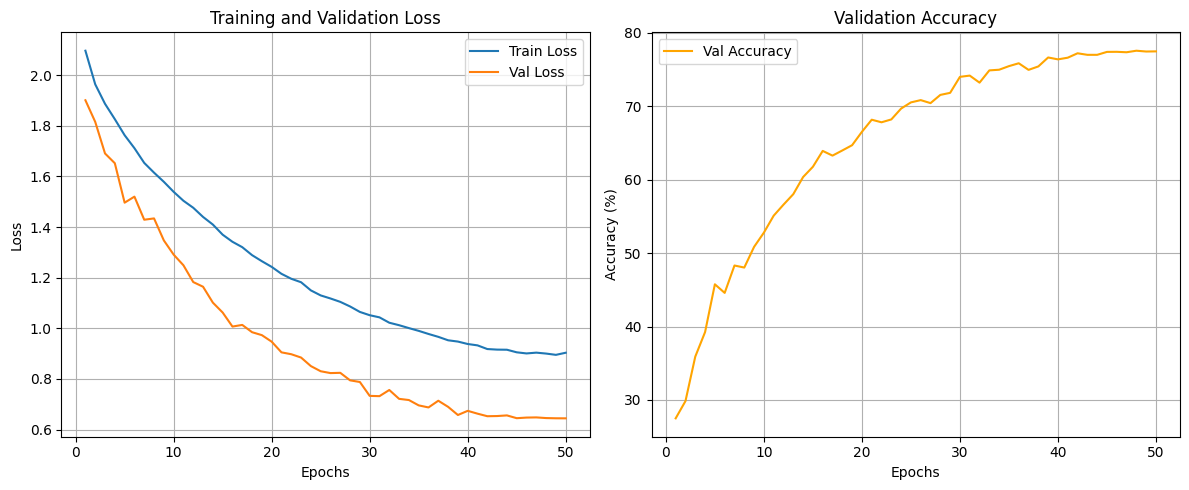

In [9]:
import matplotlib.pyplot as plt

for key, value in CONFIG.items():
    print(f"  {key}: {value}")

print("\nLoading CIFAR-10 data...")

normalize = transforms.Normalize(
    mean=[0.4914, 0.4822, 0.4465],
    std=[0.2023, 0.1994, 0.2010]
)

train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.TrivialAugmentWide(),
    transforms.ToTensor(),
    normalize
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    normalize
])

train_dataset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=train_transform
)
test_dataset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=test_transform
)

train_loader = DataLoader(
    train_dataset,
    batch_size=CONFIG['batch_size'],
    shuffle=True,
    num_workers=2,
    pin_memory=True
)
test_loader = DataLoader(
    test_dataset,
    batch_size=CONFIG['batch_size'],
    shuffle=False,
    num_workers=2,
    pin_memory=True
)
print("Data loaded successfully.")

print("Initializing ViT model...")
model = VisionTransformer(
    img_size=CONFIG['img_size'],
    patch_size=CONFIG['patch_size'],
    in_channels=CONFIG['in_channels'],
    num_classes=CONFIG['num_classes'],
    embed_dim=CONFIG['embed_dim'],
    depth=CONFIG['depth'],
    num_heads=CONFIG['num_heads'],
    mlp_ratio=CONFIG['mlp_ratio'],
    dropout=CONFIG['dropout']
).to(CONFIG['device'])

print("Setting up loss, optimizer, and scheduler...")

criterion = nn.CrossEntropyLoss()

optimizer = optim.AdamW(
    model.parameters(),
    lr=CONFIG['lr'],
    weight_decay=CONFIG['weight_decay']
)

scheduler = optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max=CONFIG['epochs']
)

scaler = GradScaler()
print("Setup complete.")

print(f"\nStarting training for {CONFIG['epochs']} epochs...")
best_acc = 0.0

history = {
    'train_loss': [],
    'val_loss': [],
    'val_acc': []
}

for epoch in range(CONFIG['epochs']):
    start_time = time.time()

    train_loss = train_one_epoch(
        model, train_loader, optimizer, criterion, scaler,
        CONFIG['device'], CONFIG['grad_clip_val']
    )

    val_loss, val_acc = evaluate(
        model, test_loader, criterion, CONFIG['device']
    )

    scheduler.step()

    end_time = time.time()
    epoch_duration = end_time - start_time

    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    print(f"Epoch {epoch+1}/{CONFIG['epochs']} | "
          f"Time: {epoch_duration:.2f}s | "
          f"Train Loss: {train_loss:.4f} | "
          f"Val Loss: {val_loss:.4f} | "
          f"Val Acc: {val_acc:.2f}%")

    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), 'vit_cifar10_best.pth')
        print(f"  -> New best accuracy! Model saved to 'vit_cifar10_best.pth'")

print("\nTraining finished!")
print(f"Best validation accuracy: {best_acc:.2f}%")

print("\nPlotting training history...")
epochs_range = range(1, CONFIG['epochs'] + 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, history['train_loss'], label='Train Loss')
plt.plot(epochs_range, history['val_loss'], label='Val Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epochs_range, history['val_acc'], label='Val Accuracy', color='orange')
plt.title('Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()